##Search algorithm


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations


class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    The default heuristic is 0 and the default action cost is 1 for all states.
    When you create an instance of a subclass, specify `initial`, and `goal` states
    (or give an `is_goal` method) and perhaps other keyword args for the subclass."""

    def __init__(self, initial=None, goal=None, **kwds):
        self.__dict__.update(initial=initial, goal=goal, **kwds)

    def actions(self, state):        raise NotImplementedError
    def result(self, state, action): raise NotImplementedError
    def is_goal(self, state):        return state == self.goal
    def action_cost(self, s, a, s1): return 1
    def h(self, node):               return 0

    def __str__(self):
        return '{}({!r}, {!r})'.format(
            type(self).__name__, self.initial, self.goal)


class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))#override len()
    def __lt__(self, other): return self.path_cost < other.path_cost#overload operator <


failure = Node('failure', path_cost=math.inf) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=math.inf) # Indicates iterative deepening search was cut off.


def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.action_cost(s, action, s1)
        yield Node(s1, node, action, cost)#ritorna lista di nodi


def path_actions(node):
    "The sequence of actions to get to this node."
    if node.parent is None:
        return []
    return path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None):
        return []
    return path_states(node.parent) + [node.state]

FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): #key è una funzione che di default ritorna il parametero stesso
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)

    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]

    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

In [ ]:
def breadth_first_search(problem):
    "Search shallowest nodes in the search tree first."
    node = Node(problem.initial)
    if problem.is_goal(problem.initial):
        return node
    frontier = FIFOQueue([node])
    reached = {problem.initial}
    while frontier:
        node = frontier.pop()
        for child in expand(problem, node):
            s = child.state
            if problem.is_goal(s):
                return child
            if s not in reached:
                reached.add(s)
                frontier.appendleft(child)
    return failure


def iterative_deepening_search(problem):
    "Do depth-limited search with increasing depth limits."
    for limit in range(1, sys.maxsize):
        result = depth_limited_search(problem, limit)
        if result != cutoff:
            return result


def depth_limited_search(problem, limit=10):
    "Search deepest nodes in the search tree first."
    frontier = LIFOQueue([Node(problem.initial)])
    result = failure
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        elif len(node) >= limit:
            result = cutoff
        elif not is_cycle(node):
            for child in expand(problem, node):
                frontier.append(child)
    return result


def depth_first_recursive_search(problem, node=None):
    if node is None:
        node = Node(problem.initial)
    if problem.is_goal(node.state):
        return node
    elif is_cycle(node):
        return failure
    else:
        for child in expand(problem, node):
            result = depth_first_recursive_search(problem, child)
            if result:
                return result
        return failure

In [ ]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    node = Node(problem.initial)
    frontier = PriorityQueue([node], key=f)
    reached = {problem.initial: node}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure

def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda n: g(n) + h(n))

def greedy_bfs(problem, h=None):
    """Search nodes with minimum h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=h)

def g(n): return n.path_cost

In [ ]:
airDistance={
        'A':366,
        'B':0,
        'C':160,
        'D':242,
        'E':161,
        'F':176,
        'G':77,
        'H':151,
        'I':226,
        'L':244,
        'M':241,
        'N':234,
        'O':380,
        'P':100,
        'R':193,
        'S':253,
        'T':329,
        'U':80,
        'V':199,
        'Z':374
    }


class RouteProblem(Problem):
    """A problem to find a route between locations on a `Map`.
    Create a problem with RouteProblem(start, goal, map=Map(...)}).
    States are the vertexes in the Map graph; actions are destination states."""

    def actions(self, state):
        """The places neighboring `state`."""
        return self.map.neighbors[state]

    def result(self, state, action):
        """Go to the `action` place, if the map says that is possible."""
        return action if action in self.map.neighbors[state] else state

    def action_cost(self, s, action, s1):
        """The distance (cost) to go from s to s1."""
        return self.map.distances[s, s1]

    def h(self, node):
        "Straight-line distance between state and the goal."
        locs = self.map.locations
        return airDistance[node.state]


class Map:
    """A map of places in a 2D world: a graph with vertexes and links between them.
    In `Map(links, locations)`, `links` can be either [(v1, v2)...] pairs,
    or a {(v1, v2): distance...} dict. Optional `locations` can be {v1: (x, y)}
    If `directed=False` then for every (v1, v2) link, we add a (v2, v1) link."""

    def __init__(self, links, locations=None, directed=False):
        if not hasattr(links, 'items'): # Distances are 1 by default
            links = {link: 1 for link in links}
        if not directed:
            for (v1, v2) in list(links):
                links[v2, v1] = links[v1, v2]
        self.distances = links
        self.neighbors = multimap(links)
        self.locations = locations or defaultdict(lambda: (0, 0))


def multimap(pairs) -> dict:
    "Given (key, val) pairs, make a dict of {key: [val,...]}."
    result = defaultdict(list) #defaultdict means that if a key is not found in the dictionary, then instead of a KeyError being thrown, a new entry is created.
    #The type of this new entry is given by the argument of defaultdict.
    for key, val in pairs:
        result[key].append(val)
    return result

romania = Map(
    {('O', 'Z'):  71, ('O', 'S'): 151, ('A', 'Z'): 75, ('A', 'S'): 140, ('A', 'T'): 118,
     ('L', 'T'): 111, ('L', 'M'):  70, ('D', 'M'): 75, ('C', 'D'): 120, ('C', 'R'): 146,
     ('C', 'P'): 138, ('R', 'S'):  80, ('F', 'S'): 99, ('B', 'F'): 211, ('B', 'P'): 101,
     ('B', 'G'):  90, ('B', 'U'):  85, ('H', 'U'): 98, ('E', 'H'):  86, ('U', 'V'): 142,
     ('I', 'V'):  92, ('I', 'N'):  87, ('P', 'R'): 97},
    {'A': ( 76, 497), 'B': (400, 327), 'C': (246, 285), 'D': (160, 296), 'E': (558, 294),
     'F': (285, 460), 'G': (368, 257), 'H': (548, 355), 'I': (488, 535), 'L': (162, 379),
     'M': (160, 343), 'N': (407, 561), 'O': (117, 580), 'P': (311, 372), 'R': (227, 412),
     'S': (187, 463), 'T': ( 83, 414), 'U': (471, 363), 'V': (535, 473), 'Z': (92, 539)})

In [ ]:
ex = RouteProblem('T', 'B', map=romania)
print(path_states(astar_search(ex)))
print(astar_search(ex).path_cost)
print("----------------")
print(path_states(greedy_bfs(ex)))
print(greedy_bfs(ex).path_cost)
print("----------------")
print(path_states(breadth_first_search(ex)))
print(breadth_first_search(ex).path_cost)

['T', 'A', 'S', 'R', 'P', 'B']
536
----------------
['T', 'L', 'M', 'D', 'C', 'P', 'B']
615
----------------
['T', 'A', 'S', 'F', 'B']
568


##Numpy array e reti bayesiane

In [ ]:
import numpy as np

Esercizio su probabilità della seguente rete bayesiana
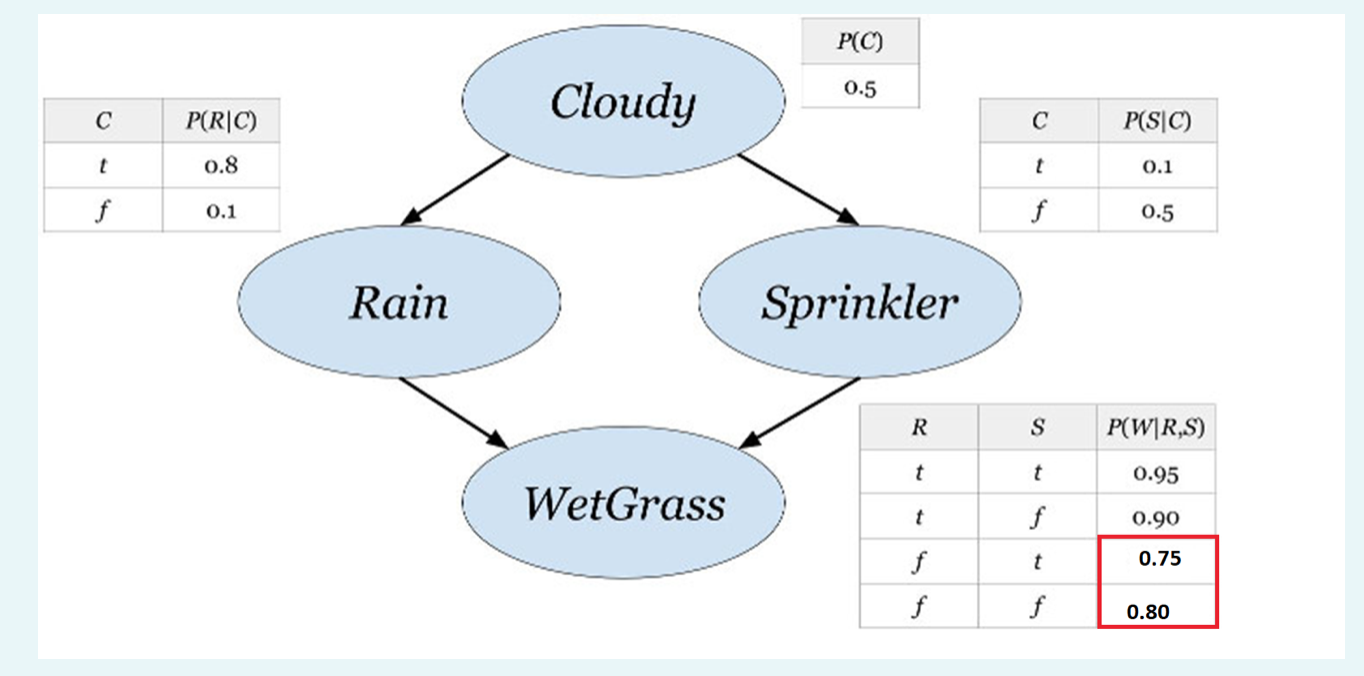

In [ ]:
t,f=0,1

PC=np.array([0.5,0.5])
PR_C=np.array([[0.8,0.1],[0.2,0.9]])
PS_C=np.array([[0.1,0.5],[0.9,0.5]])
PW_RS=np.array([[[0.95,0.90],[0.75,0.80]],[[0.05,0.1],[0.25,0.2]]])

In [ ]:
PW_C=PW_RS[:,t,t]*PR_C[t,t]*PS_C[t,t]+PW_RS[:,t,f]*PR_C[t,t]*PS_C[f,t]+PW_RS[:,f,t]*PR_C[f,t]*PS_C[t,t]+PW_RS[:,f,f]*PR_C[f,t]*PS_C[f,t]
print(PW_C)

[0.883 0.117]


ESERCIZIO SULLA SEGUENTE RETE BAYESIANA
Calcolare P(y|!x)

---


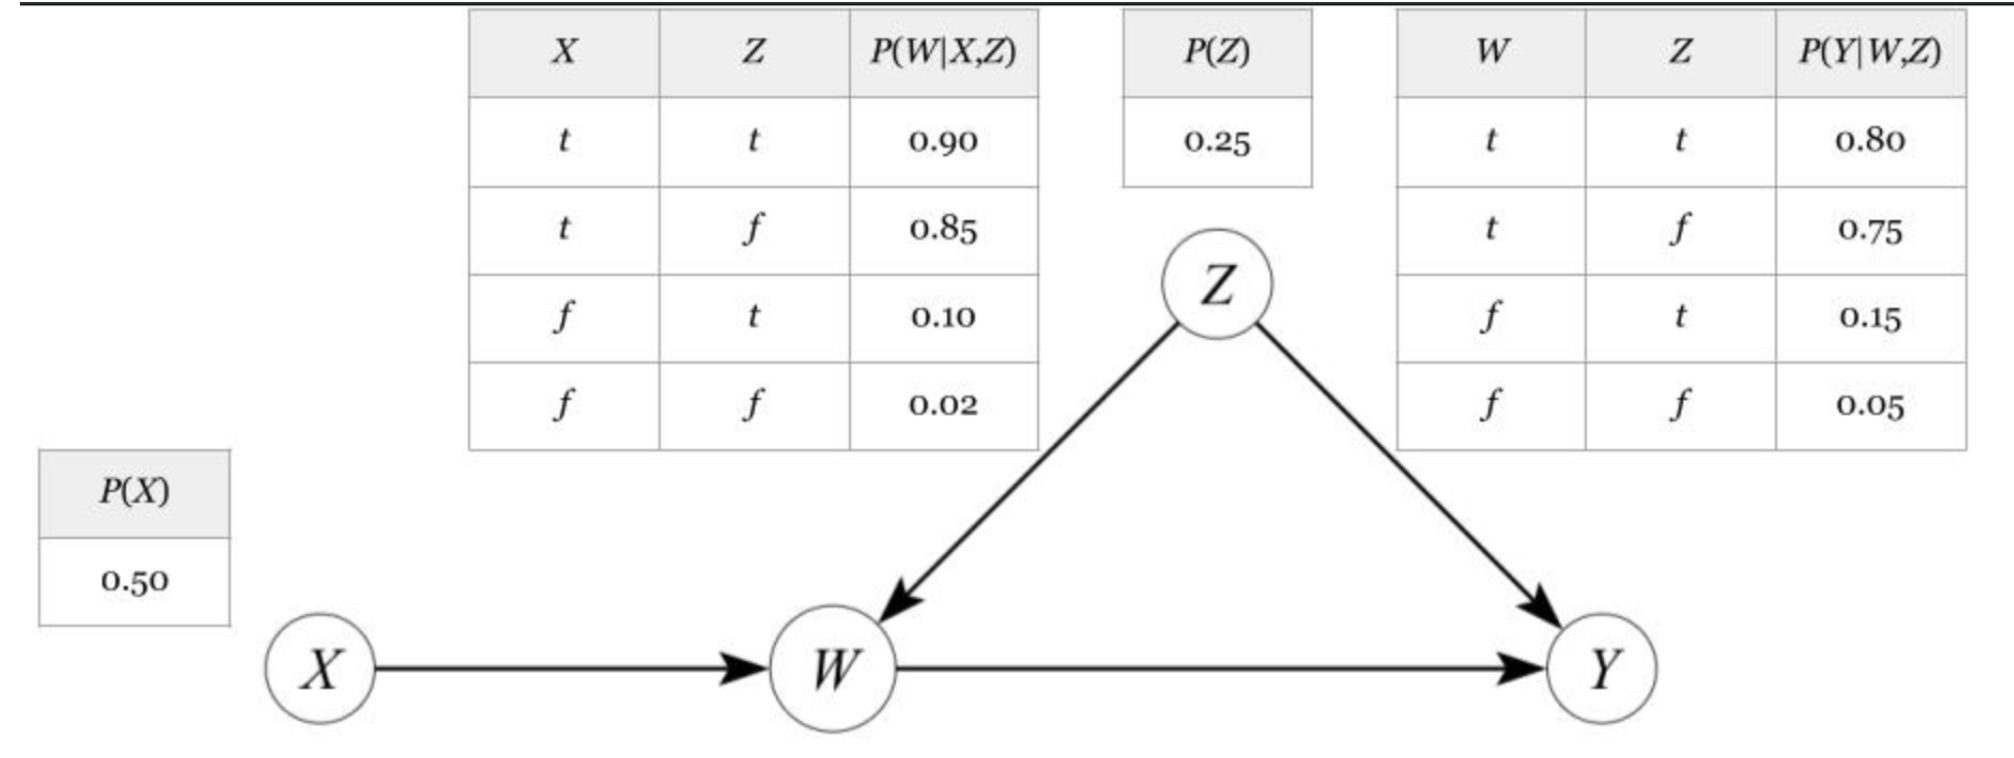

In [ ]:
t,f=0,1


PX=np.array([0.5,0.5])
PZ=np.array([0.25,0.75])


PY_WZ=np.array([[[0.8,0.75],[0.15,0.05]],[[0.2,0.25],[0.85,0.95]]])
PW_XZ=np.array([[[0.9,0.85],[0.10,0.02]],[[0.1,0.15],[0.9,0.98]]])

PW_notXZ=np.array([[0.10,0.02],[0.9,0.98]])

In [ ]:
#separato
sum_W=PY_WZ[:,t,:]*PW_XZ[t,f,:]+PY_WZ[:,f,:]*PW_XZ[f,f,:]
sum_Z=sum_W[:,t]*PZ[t]+sum_W[:,f]*PZ[f]
PY_notX=PX[f]*sum_Z[:]
a=1/(PY_notX[t]+PY_notX[f])
PY_notX=a*PY_notX[:]
print(PY_notX)

[0.10175 0.89825]


In [ ]:
#unito
PY_notX=PX[f]*(PY_WZ[:,t,t]*PW_XZ[t,f,t]*PZ[t]+PY_WZ[:,t,f]*PW_XZ[t,f,f]*PZ[f]+PY_WZ[:,f,t]*PW_XZ[f,f,t]*PZ[t]+PY_WZ[:,f,f]*PW_XZ[f,f,f]*PZ[f])

a=1/(PY_notX[t]+PY_notX[f])
PY_notX=a*PY_notX[:]

print(PY_notX)

[0.10175 0.89825]


##Pomegranate

In [ ]:
#import numpy as np
#!pip install pomegranate
#from pomegranate import *

#p1=DiscreteDistribution({'y':0.4,'n':0.6})
#p2=ConditionProbabilityTable(
#    [['y','y',0.8],
#     ['y','n',0.5],
#     ['n','y',0.2],
#     ['n','n',0.5]
#     ],[p1]
#)

#p2=ConditionProbabilityTable(
#    [['y','y',0.2],
#     ['y','n',0.3],
#     ['n','y',0.8],
#     ['n','n',0.7]
#     ],[p2]
#)

#p3=ConditionalProbabilityTable(
#    [['y','y',0.2],
#     ['y','n',0.3],
#     ['n','y',0.8],
#     ['n','n',0.7]],[p2]
#)

#p4=ConditionProbabilityTable(
#    [['y','y',0.8],
#     ['y','n',0.5],
#     ['n','y',0.2],
#     ['n','n',0.5]
#     ],[p2]
#)
#n1=Node(p1,'p1')
#n2=Node(p2,'p2')
#n3=Node(p3,'p3')
#n4=Node(p4,'p4')
#model=BayesianNetwork("Network")
#model.add_states(n1,n2,n3,n4,n5)
#model.add_edge(n1,n2)
#model.add_edge(n2,n3)
#model.add_edge(n2,n4)
#model.bake()

#scenario=[[None,None,'n','y']]

#res=model.predict_proba(scenario)
#print(res[0])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


##Pyagrum


In [ ]:
!pip install pyAgrum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 6.1 MB/s eta 0:00:00


In [ ]:
from IPython.display import display, Math, Latex
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.causal as csl
import pyAgrum.causal.notebook as cslnb

**Drug, patient, gender**

In [ ]:
modelGender=gum.fastBN("Gender{F|M}->Drug{Without|With}->Patient{Sick|Healed}<-Gender")

modelGender.cpt("Gender")[:]=[0.5,0.5]
modelGender.cpt("Drug")[:]=[[0.25,0.75],
                            [0.65,0.35]]

modelGender.cpt("Patient")[{"Gender":"F", "Drug":"Without"}]=[0.2,0.8]
modelGender.cpt("Patient")[{"Gender":"F", "Drug":"With"}]=[0.3,0.7]
modelGender.cpt("Patient")[{"Gender":"M", "Drug":"Without"}]=[0.6,0.4]
modelGender.cpt("Patient")[{"Gender":"M", "Drug":"With"}]=[0.8,0.2]

gnb.flow.row(modelGender, modelGender.cpt("Gender"), modelGender.cpt("Drug"), modelGender.cpt("Patient"))

In [ ]:
modelGenderCausal=csl.CausalModel(modelGender)
gnb.flow.row(modelGenderCausal)

In [ ]:
cslnb.showCausalImpact(modelGenderCausal, "Patient", doing="Drug", values={"Drug":"Without"})

In [ ]:
model=gum.fastBN("Z{t|f}->X{t|f}->Y{t|f}<-S{t|f}->X<-K{t|f}->W{t|f}->G{t|f}<-Y<-F{t|f}<-E{t|f}<-Z")

gnb.flow.row(model)

In [ ]:
modelSmoking=gum.fastBN("S{t|f}->T{t|f}->C{t|f}")


modelSmoking.cpt('S')[:]=[0.5,0.5]

modelSmoking.cpt('T')[:]=[[0.95,0.05],#s=true
                          [0.05,0.95]]#s=false

modelSmoking.cpt('C')[{'T':'t'}]=[0.55,0.45]#P(C|t,s)P(s)+P(C|t,!s)P(!s)
modelSmoking.cpt('C')[{'T':'f'}]=[0.5,0.5]

gnb.flow.row(modelSmoking,modelSmoking.cpt("S"),modelSmoking.cpt("T"),modelSmoking.cpt("C"))

causalSmoking=csl.CausalModel(modelSmoking, [("lat1",['S','C'])])

#cslnb.showCausalModel(causalSmoking)

cslnb.showCausalImpact(causalSmoking,'C',doing='S',values={'S':'t'})

##Casual graphical models

In [1]:
!pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!sed -i 's/collections/collections.abc/g' /usr/local/lib/python3.10/dist-packages/causalgraphicalmodels/cgm.py

from causalgraphicalmodels import CausalGraphicalModel

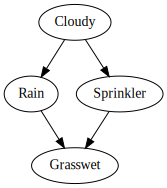

In [ ]:
mSprinkler=CausalGraphicalModel(
    nodes=['Sprinkler','Rain','Cloudy','Grasswet'],
    edges=[
        ('Cloudy','Rain'),
        ('Cloudy','Sprinkler'),
        ('Sprinkler','Grasswet'),
        ('Rain','Grasswet')
    ]

)

mSprinkler.draw()

In [ ]:
mSprinkler.get_distribution()

'P(Cloudy)P(Rain|Cloudy)P(Sprinkler|Cloudy)P(Grasswet|Sprinkler,Rain)'

In [ ]:
print(mSprinkler.get_all_backdoor_paths('Grasswet','Cloudy'))
print(mSprinkler.get_all_backdoor_adjustment_sets('Grasswet','Cloudy'))
print(mSprinkler.get_all_frontdoor_adjustment_sets('Cloudy','Grasswet'))

[['Grasswet', 'Sprinkler', 'Cloudy'], ['Grasswet', 'Rain', 'Cloudy']]
frozenset({frozenset({'Rain', 'Sprinkler'})})
frozenset({frozenset({'Rain', 'Sprinkler'})})


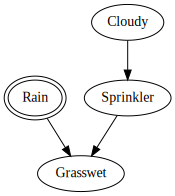

In [ ]:
mSprinkler_do=mSprinkler.do('Rain')
mSprinkler_do.draw()

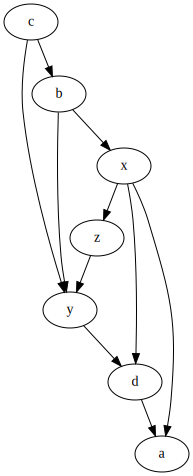

In [3]:
modelExam=CausalGraphicalModel(
    nodes=['x','y','a','b','c','d','z'],
    edges=[
        ('x','z'),
        ('z','y'),
        ('y','d'),
        ('d','a'),
        ('x','a'),
        ('b','x'),
        ('c','b'),
        ('b','y'),
        ('c','y'),
        ('x','d')
    ]

)

modelExam.draw()

In [ ]:
modelExam.get_all_backdoor_paths('z','d')

[['z', 'x', 'a', 'd'],
 ['z', 'x', 'd'],
 ['z', 'x', 'b', 'y', 'd'],
 ['z', 'x', 'b', 'c', 'y', 'd']]

In [ ]:
modelExam.get_all_backdoor_paths('y','d')

[['y', 'b', 'x', 'a', 'd'],
 ['y', 'b', 'x', 'd'],
 ['y', 'c', 'b', 'x', 'a', 'd'],
 ['y', 'c', 'b', 'x', 'd'],
 ['y', 'z', 'x', 'a', 'd'],
 ['y', 'z', 'x', 'd']]

In [ ]:
modelExam.get_all_backdoor_adjustment_sets('y','d')

frozenset({frozenset({'b', 'c', 'x'}),
           frozenset({'b', 'z'}),
           frozenset({'x'}),
           frozenset({'b', 'x'}),
           frozenset({'x', 'z'}),
           frozenset({'b', 'x', 'z'}),
           frozenset({'c', 'x'}),
           frozenset({'b', 'c', 'z'}),
           frozenset({'c', 'x', 'z'}),
           frozenset({'b', 'c', 'x', 'z'})})

In [ ]:
modelExam.get_all_backdoor_adjustment_sets('z','d')

frozenset({frozenset({'x'}),
           frozenset({'b', 'x'}),
           frozenset({'c', 'x'}),
           frozenset({'b', 'c', 'x'})})

In [5]:
modelExam.is_d_separated('z','d',{'x','y','b','c'})

True

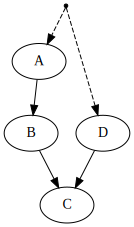

In [ ]:
m1=CausalGraphicalModel(
    nodes=['A','B','C','D'],
    edges=[
        ('A','B'),
        ('B','C'),
        ('D','C')
    ],
    latent_edges=[('D','A')]
)

m1.draw()

In [ ]:
print(m1.get_all_backdoor_paths('A','C'))
print(m1.get_all_backdoor_adjustment_sets('A','C'))

[['A', 'Unobserved_0', 'D', 'C']]
frozenset({frozenset({'D'})})


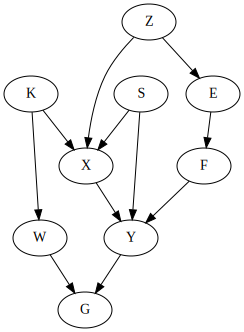

In [ ]:
model=CausalGraphicalModel(
    nodes=['Z','E','F','Y','X','S','K','W','G'],
    edges=[
        ('Z','E'),
        ('E','F'),
        ('Z','X'),
        ('X','Y'),
        ('S','X'),
        ('S','Y'),
        ('K','X'),
        ('K','W'),
        ('W','G'),
        ('Y','G'),
        ('F','Y')
    ]
)

model.draw()

In [ ]:
model.get_all_backdoor_paths('X','Y')

[['X', 'Z', 'E', 'F', 'Y'], ['X', 'S', 'Y'], ['X', 'K', 'W', 'G', 'Y']]

In [ ]:
model.get_all_backdoor_adjustment_sets('X','Y')

frozenset({frozenset({'E', 'F', 'S'}),
           frozenset({'E', 'K', 'S'}),
           frozenset({'E', 'S', 'W'}),
           frozenset({'S', 'Z'}),
           frozenset({'E', 'S', 'Z'}),
           frozenset({'E', 'S', 'W', 'Z'}),
           frozenset({'F', 'K', 'S', 'W'}),
           frozenset({'K', 'S', 'Z'}),
           frozenset({'F', 'S'}),
           frozenset({'F', 'K', 'S', 'W', 'Z'}),
           frozenset({'E', 'F', 'S', 'Z'}),
           frozenset({'F', 'S', 'W'}),
           frozenset({'E', 'S'}),
           frozenset({'E', 'F', 'S', 'W'}),
           frozenset({'E', 'F', 'K', 'S'}),
           frozenset({'E', 'K', 'S', 'W'}),
           frozenset({'E', 'K', 'S', 'Z'}),
           frozenset({'F', 'S', 'Z'}),
           frozenset({'E', 'F', 'K', 'S', 'Z'}),
           frozenset({'S', 'W', 'Z'}),
           frozenset({'K', 'S', 'W', 'Z'}),
           frozenset({'E', 'K', 'S', 'W', 'Z'}),
           frozenset({'F', 'S', 'W', 'Z'}),
           frozenset({'E', 'F', 'K', 'S', '

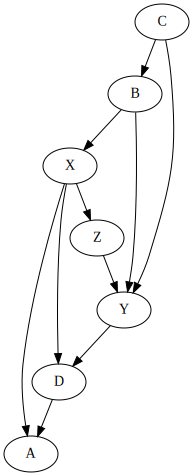

In [ ]:
offer = CausalGraphicalModel(
    nodes=["X", "B", "Z", "Y","C","D","A"],
    edges=[
        ("X" , "Z"),
        ("Z","Y"),
        ("Y","D"),
        ("X","A"),
        ("D","A"),
        ("B", "X" ),
        ("C" , "B"),
        ("X","D"),
        ("B","Y"),
        ("C","Y")
    ]
)

offer.draw()

In [ ]:
offer.get_all_backdoor_adjustment_sets("Z","D")

frozenset({frozenset({'X'}),
           frozenset({'C', 'X'}),
           frozenset({'B', 'X'}),
           frozenset({'B', 'C', 'X'})})

In [ ]:
print(offer.is_d_separated("Z","D",{"X","Y"}))
print(offer.is_d_separated("Z","D",{"X","Y","B","C"}))

True
True


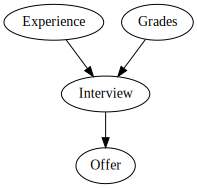

In [ ]:
modelEsame = CausalGraphicalModel(
    nodes=["Experience", "Grades", "Interview", "Offer"],
    edges=[
        ("Experience" , "Interview"),
        ("Grades", "Interview" ),
        ("Interview" , "Offer"),
    ]
)
modelEsame.draw()

In [ ]:
modelEsame.get_distribution()

'P(Experience)P(Grades)P(Interview|Experience,Grades)P(Offer|Interview)'

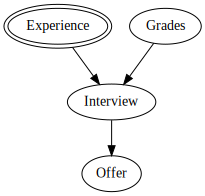

In [ ]:
modelesame_do=modelEsame.do("Experience")
modelesame_do.draw()

##MDP toolbox and Markov decision processes

In [ ]:
import numpy as np
!pip install pymdptoolbox
import mdptoolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-py3-none-any.whl size=25656 sha256=5d7b4b7afb9538dd0567acbf0439a06b9f61b41cf35ab2ead4a00153cb0d2b47
  Stored in directory: /root/.cache/pip/wheels/2b/e7/c7/d7abf9e309f3573a934fed2750c70bd75d9e9d901f7f16e183
Successfully built pymdptoolbox


In [ ]:
office_outcomes=np.array(['done','distracted','talk'])
office_utility=np.array([8,1,5])
office_probability=np.array([0.5,0.3,0.2])

coffee_outcome=np.array(['enjoy','sppiling'])
coffee_utility=np.array([10,-20])
coffee_probability=np.array([0.95,0.05])

In [ ]:
eu_office=np.dot(office_utility, office_probability)
eu_coffee=np.dot(coffee_utility, coffee_probability)

print(eu_office)
print(eu_coffee)

5.3
8.5


In [ ]:
if eu_office > eu_coffee:
    print('Office is the MEU choice')
else:
    print('Coffee is the MEU choice')

Coffee is the MEU choice


In [ ]:
max_coffee=np.max(coffee_utility)
max_office=np.max(office_utility)
if max_office > max_coffee:
    print('Office is the Maximax choice')
else:
    print('Coffee is the Maximax choice')

Coffee is the Maximax choice


In [ ]:
min_coffee=np.min(coffee_utility)
min_office=np.min(office_utility)
if min_office > min_coffee:
    print('Office is the Maximin choice')
else:
    print('Coffee is the Maximin choice')

Office is the Maximin choice


In [ ]:
Probability=np.array(
    [[[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]],
     [[0.2,0.8,0,0],[0,0.2,0.8,0],[0,0,0.2,0.8],[0,0,0,1]]]
)

Reward=np.array([[-0.04,0.04],[-0.04,-0.04],[-0.04,0.04],[1,1]])

mdptoolbox.util.check(Probability, Reward)

m=mdptoolbox.mdp.ValueIteration(Probability, Reward, 0.9)
m.run()
print(m.policy)
print(m.V)

m=mdptoolbox.mdp.PolicyIteration(Probability, Reward, 0.9)
m.run()
print(m.policy)
print(m.V)


m=mdptoolbox.mdp.QLearning(Probability, Reward, 0.9)
m.run()
print(m.policy)
print(m.V)

(1, 1, 1, 0)
(2.938992723166012, 3.829551694786357, 4.955063634908439, 6.12579511)
(1, 1, 1, 0)
(6.813046821723428, 7.703747769185013, 8.82926829268293, 10.000000000000002)
(1, 1, 1, 1)
(0.26813785312878424, 2.3605537622254613, 6.562486352555612, 9.999999824576916)


##Scikit learn

In [ ]:
!pip install scikit-learn
from sklearn import datasets
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import numpy as np

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
wine_ds=datasets.load_wine()
print(len(wine_ds.data))
print(wine_ds.data.shape)
print(wine_ds.target.shape)
print(np.unique(wine_ds.target))

print(wine_ds.target)

178
(178, 13)
(178,)
[0 1 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
data=wine_ds.data.reshape(len(wine_ds.data), -1)
x_train, x_test, y_train, y_test=train_test_split(data, wine_ds.target, test_size=0.3)

print(x_test[1])

[ 13.84   4.12   2.38  19.5   89.     1.8    0.83   0.48   1.56   9.01
   0.57   1.64 480.  ]


In [ ]:
mean_accuracy={}
std_accuracy={}

for k in np.logspace(-20,0,20):
  clf=svm.SVC(kernel='linear',C=k)
  scores=cross_val_score(clf, data, wine_ds.target, cv=10)
  mean_accuracy[k]=np.mean(scores)
  std_accuracy[k]=np.std(scores)

In [ ]:
max_c=max(mean_accuracy, key=mean_accuracy.get)
print(max_c)

0.08858667904100796


              precision    recall  f1-score   support

           0       0.94      1.00      0.97        17
           1       0.96      0.96      0.96        24
           2       1.00      0.92      0.96        13

    accuracy                           0.96        54
   macro avg       0.97      0.96      0.96        54
weighted avg       0.96      0.96      0.96        54



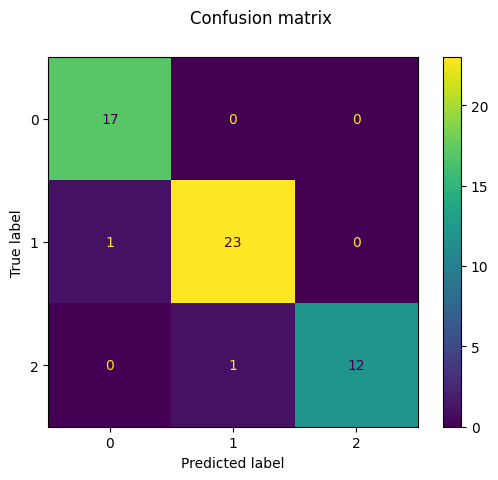

In [ ]:
clf=svm.SVC(kernel='linear', C=max_c)
clf.fit(x_train, y_train)
predicted=clf.predict(x_test)
print(metrics.classification_report(y_test, predicted))

disp=metrics.ConfusionMatrixDisplay.from_predictions(y_test,predicted)
disp.figure_.suptitle('Confusion matrix')
plt.show()

In [ ]:
ds=datasets.load_digits()

print(len(ds.data))
print(ds.data.shape)
print(ds.target.shape)

1797
(1797, 64)
(1797,)


In [ ]:
data=ds.data.reshape(len(ds.data),-1)

x_train, x_test, y_train, y_test=train_test_split(data, ds.target, test_size=0.3)

In [ ]:
mean_accuracy={}

for i in np.logspace(-20,0,20):
  clf=svm.SVC(C=i)
  scores=cross_val_score(clf,data, ds.target, cv=5)
  mean_accuracy[i]=np.mean(scores)

In [ ]:
max_c=max(mean_accuracy, key=mean_accuracy.get)
print(max_c)

1.0


In [ ]:
clf=svm.SVC(C=max_c)
clf.fit(x_train, y_train)

SVC()

In [ ]:
predicted=clf.predict(x_test)

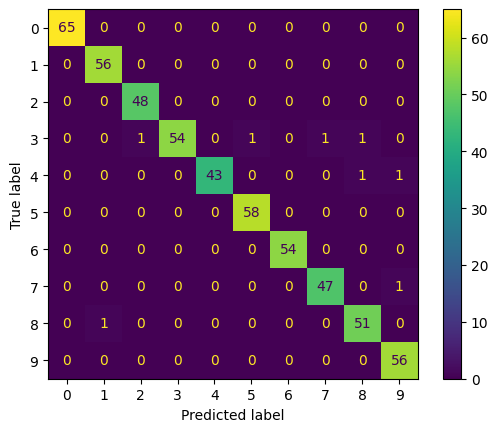

In [ ]:

metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)

plt.show()

##Keras

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import datasets
from tensorflow.keras import optimizers
from tensorflow.keras import losses

In [ ]:
!pip install gdown
import gdown
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# The following lines allows to exploit the GPU and make the training faster (Check in the Runtime - Change Runtime time if the GPU is set)
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
(x_train,y_train),(x_test,y_test)=datasets.cifar10.load_data()
print(len(x_train))
print(len(y_train))

170498071/170498071 [==============================] - 13s 0us/step
50000
50000


[7]


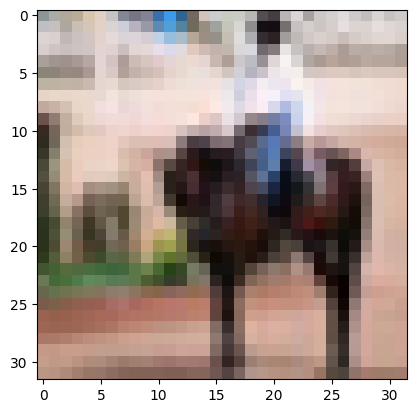

In [ ]:
plt.imshow(x_train[11])
print(y_train[11])

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))

val_ds, train_ds=keras.utils.split_dataset(train_ds,left_size=0.3)

train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)

In [ ]:
#batchs_size=100

#val_ds=val_ds.batch(batchs_size)
#test_ds=test_ds.batch(batchs_size)
#train_ds=train_ds.batch(batchs_size)

#train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
#val_ds = val_ds.prefetch(tf.data.AUTOTUNE)
#test_ds=test_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
#train_ds_iterator = train_ds.as_numpy_iterator()
#batch = train_ds_iterator.next()
#print(batch[0].shape)
#print(batch[1].shape)

(100, 32, 32, 3)
(100, 1)


In [ ]:
train_ds = train_ds.map(lambda x,y: (x/255, y))
val_ds = val_ds.map(lambda x,y: (x/255, y))
test_ds=test_ds.map(lambda x,y: (x/255, y))

In [ ]:
model=models.Sequential()

model.add(layers.Conv2D(32, (3, 3), 1, activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3), activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

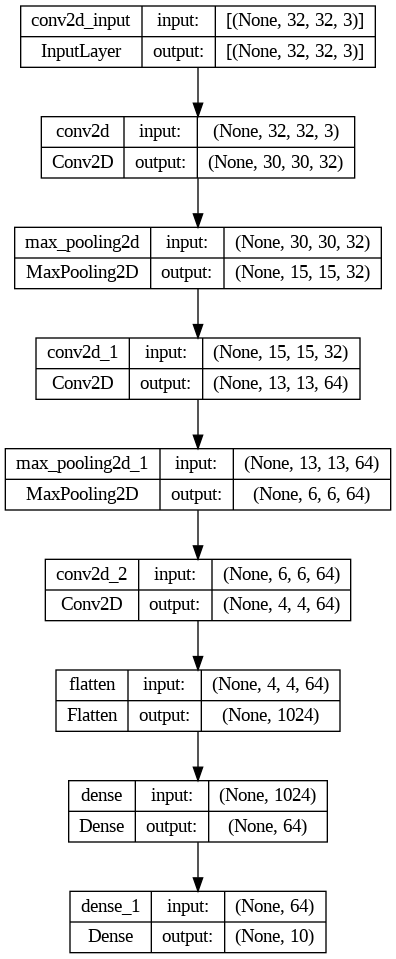

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epc=10

model.compile(
    optimizer='adam',
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#hist = model.fit(
#    train_ds,
#    epochs=epochs,
#    validation_data=val_ds,
#    batch_size=batch_size
#)

In [ ]:
x_train=x_train/255
x_test=x_test/255

hist = model.fit(x_train, y_train, epochs=epc)

Epoch 1/10
1563/1563 [==============================] - 17s 5ms/step - loss: 1.5178 - accuracy: 0.4470
Epoch 2/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.1407 - accuracy: 0.5968
Epoch 3/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9859 - accuracy: 0.6516
Epoch 4/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8865 - accuracy: 0.6899
Epoch 5/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.8182 - accuracy: 0.7124
Epoch 6/10
1563/1563 [==============================] - 7s 4ms/step - loss: 0.7566 - accuracy: 0.7340
Epoch 7/10
1563/1563 [==============================] - 8s 5ms/step - loss: 0.7129 - accuracy: 0.7507
Epoch 8/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.6706 - accuracy: 0.7655
Epoch 9/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6285 - accuracy: 0.7786
Epoch 10/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0

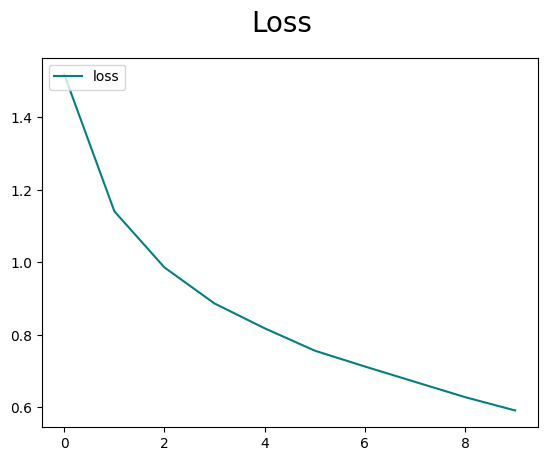

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
#plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

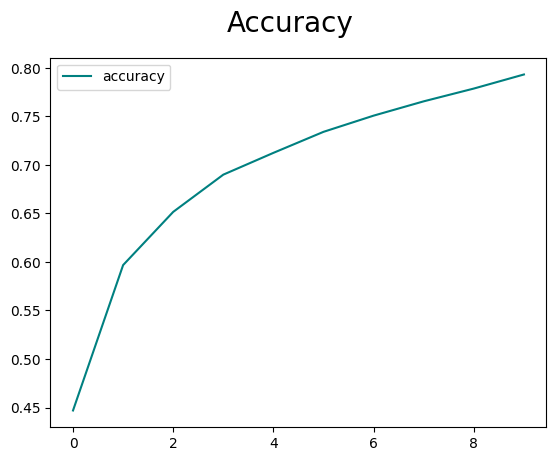

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
#plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
# Evaluate the model
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.8442916870117188
Test accuracy: 0.7229999899864197


In [ ]:
k=0
predict=model.predict(x_test)
print(predict)
print(len(y_test))
print(len(predict))
for i in range(0,len(predict)):
  if np.argmax(predict[i])==y_test[i]:
    k+=1
print(str(k)+" su "+str(len(predict)))
print(str((k*100)/len(y_test))+"%")


313/313 [==============================] - 2s 4ms/step
[[-1.9318057  -3.1231778   0.17924176 ... -2.16833     1.7239828
  -3.341582  ]
 [ 2.0980325   8.585036   -8.954109   ... -9.915547    9.736613
   5.0732026 ]
 [ 2.0736263   1.6221534  -1.8240695  ... -1.5649253   2.311894
   0.25804788]
 ...
 [-5.265906   -5.0317736   0.761912   ...  4.9596233  -1.7603002
  -4.171337  ]
 [-0.25460932  5.416058   -2.9287298  ... -1.2086803   0.72116137
  -0.66128725]
 [-6.0821533  -5.59804     0.18781142 ... 13.0917425  -7.0344396
  -4.823629  ]]
10000
10000
7230 su 10000
72.3%
